In [4]:
### Loading the Dataset

try: from datasets import load_dataset
except:
    !pip install datasets
    from datasets import load_dataset


# dataset = load_dataset("nvidia/OpenMathInstruct-2", split = "train_1M")
dataset = load_dataset("commonsense_qa")
# dataset_small = dataset.select(range(10000))
# dataset_split = dataset_small.train_test_split(test_size=0.1, seed=42)
# train_data, eval_data = dataset_split["train"], dataset_split["test"]
train_data, eval_data = dataset["train"], dataset["validation"]

print(train_data)

Dataset({
    features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
    num_rows: 9741
})


In [5]:
eval_data.to_pandas()['question_concept'].value_counts().to_csv("eval_data_concept.csv")

In [6]:
### Logging into HuggingFace

try:
  from dotenv import load_dotenv
except:
  !pip install python-dotenv
  from dotenv import load_dotenv

from huggingface_hub import login, whoami
import os

load_dotenv()
login(os.getenv("hugging_face_key2"))

In [7]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_model, PrefixTuningConfig, TaskType


model_name = "gpt2"
# model_name = "tiiuae/falcon-7b"
# model_name = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)

peft_config = PrefixTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    num_virtual_tokens=10,        # prefix length
    prefix_projection=True,       # optional MLP projection of prefix
)

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 14,772,480 || all params: 139,212,288 || trainable%: 10.6115


In [9]:
# def format_prompt(example):
#     text = f"[INST] Problem: {example['problem']} [/INST] Solution: {example['generated_solution']}"
#     tokenized = tokenizer(
#         text,
#         padding="max_length",
#         truncation=True,
#         max_length=512
#     )
#     tokenized["labels"] = tokenized["input_ids"].copy()
#     return tokenized

# tokenized_train = train_data.map(format_prompt, batched=False, remove_columns=train_data.column_names)
# tokenized_eval = eval_data.map(format_prompt, batched=False, remove_columns=eval_data.column_names)

# tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
# tokenized_eval.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])



import numpy as np
def format_prompt(example):
    question = example['question']
    choices = example['choices']['text']
    labels = example['choices']['label']
    answer_key = example['answerKey']

    # Find the correct answer text
    answer_index = labels.index(answer_key)
    answer_text = choices[answer_index]

    # Create the prompt
    prompt = f"Q: {question}\nO: {' /// '.join(choices)}\nA: "
    full_text = prompt + " " + answer_text

    # Tokenize full input
    tokenized = tokenizer(
        full_text,
        padding="max_length",
        truncation=True,
        max_length=128,
    )

    # Calculate where the completion starts
    prompt_ids = tokenizer(prompt,
                           truncation=True,
                           max_length=128)["input_ids"]
    completion_start = len(prompt_ids)

    # Mask prompt tokens in the labels
    labels = [-np.inf] * completion_start + tokenized["input_ids"][completion_start:]
    labels += [-np.inf] * (128 - len(labels))  # pad label to match input

    tokenized["labels"] = labels
    return tokenized


tokenized_train = train_data.map(format_prompt, batched=False, remove_columns=train_data.column_names)
tokenized_eval = eval_data.map(format_prompt, batched=False, remove_columns=eval_data.column_names)

tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_eval.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [10]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)


training_args = TrainingArguments(
    output_dir=f"./prefix_{model_name}",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="steps",
    eval_steps=100,
    save_steps=1000,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",

)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
)


trainer.train()



No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
100,3.912700,3.130897
200,3.127000,2.973093
300,2.981700,2.894090
400,2.956700,2.887203
500,2.880700,2.832269
600,2.863700,2.815427
700,2.852900,2.798955
800,2.831300,2.773692
900,2.798700,2.759981
1000,2.806500,2.746932


TrainOutput(global_step=3654, training_loss=2.7759123093845677, metrics={'train_runtime': 300.4688, 'train_samples_per_second': 97.258, 'train_steps_per_second': 12.161, 'total_flos': 1908934262784000.0, 'train_loss': 2.7759123093845677, 'epoch': 3.0})

In [11]:
peft_model.save_pretrained(f"./prefix_{model_name}_final")
tokenizer.save_pretrained(f"./prefix_{model_name}_final")

('./prefix_gpt2_final/tokenizer_config.json',
 './prefix_gpt2_final/special_tokens_map.json',
 './prefix_gpt2_final/vocab.json',
 './prefix_gpt2_final/merges.txt',
 './prefix_gpt2_final/added_tokens.json',
 './prefix_gpt2_final/tokenizer.json')

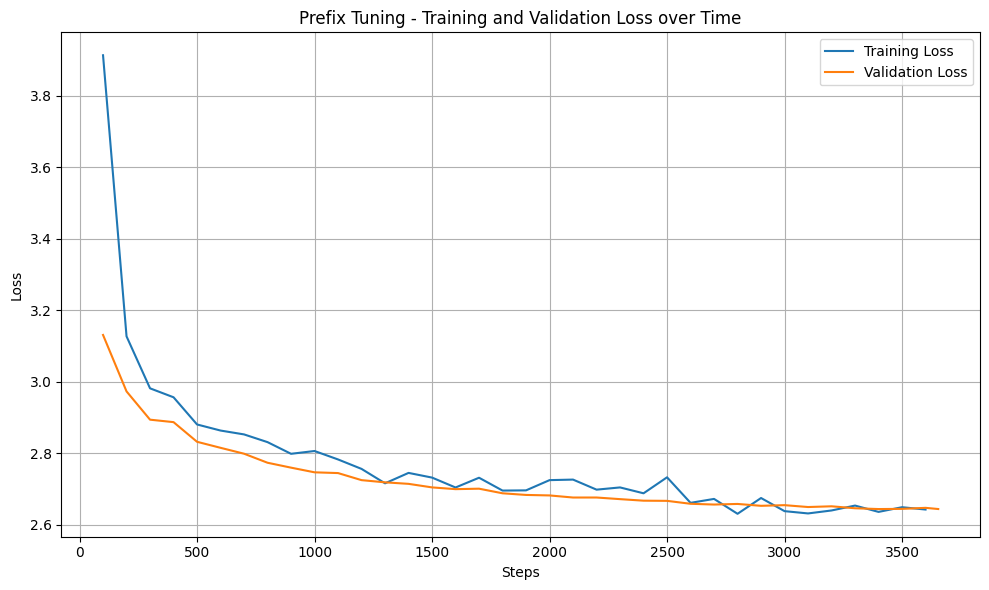

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log history
logs = trainer.state.log_history

# Convert to DataFrame
df = pd.DataFrame(logs)

# Plot Training and Evaluation Loss
plt.figure(figsize=(10, 6))

# Plot training loss
if 'loss' in df.columns:
    plt.plot(df["step"][df["loss"].notna()], df["loss"].dropna(), label="Training Loss")

# Plot evaluation loss
if 'eval_loss' in df.columns:
    plt.plot(df["step"][df["eval_loss"].notna()], df["eval_loss"].dropna(), label="Validation Loss")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Prefix Tuning - Training and Validation Loss over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from peft import PeftModel, PeftConfig
peft_config = PeftConfig.from_pretrained(f"./prefix_{model_name}_final")

base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path)
peft_model = PeftModel.from_pretrained(base_model, f"./prefix_{model_name}_final")

tokenizer = AutoTokenizer.from_pretrained(f"./prefix_{model_name}_final")

In [14]:
from transformers import pipeline
import torch
from tqdm import tqdm
from collections import defaultdict

# Use the PEFT model (already trained) and tokenizer
peft_model.eval()
pipe = pipeline("text-generation", model=peft_model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

def format_prompt(example):
    question = example["question"]
    choices = example["choices"]["text"]
    prompt = f"Q: {question}\nO: {' /// '.join(choices)}\nA: "
    return prompt, choices

correct = 0
total = 0
half_correct = 0

# For concept-wise tracking
concept_stats = defaultdict(lambda: {"correct": 0.0, "total": 0})

for example in tqdm(eval_data, total=len(eval_data)):
    prompt, choices = format_prompt(example)

    # Generate prediction
    output = pipe(prompt, max_new_tokens=10, do_sample=False, eos_token_id=tokenizer.eos_token_id)[0]["generated_text"]

    # Extract generated answer (after "Answer:")
    generated = [ans.strip()  for ans in output.split("\n")[2].split("A:")[-1].strip().split(" /// ")]

    # Get ground truth
    answer_key = example["answerKey"]
    labels = example["choices"]["label"]
    true_answer = example["choices"]["text"][labels.index(answer_key)].strip()

    # Track concept-wise stats
    concept = example["question_concept"]

    if generated[0] == true_answer:
        correct += 1
        concept_stats[concept]["correct"] += 1
    elif true_answer in generated:
        correct += 0.5
        half_correct += 1
        concept_stats[concept]["correct"] += 0.5
    concept_stats[concept]["total"] += 1

    total += 1

# Final overall accuracy
accuracy = correct / total
print(f"\nOverall Accuracy: {accuracy:.2%}")
print(f"Half-correct answers: {half_correct} out of {total}")

# # Per-concept accuracy
# print("\nPer-concept Accuracy:")
# for concept, stats in sorted(concept_stats.items(), key=lambda x: x[1]["total"], reverse=True):
#     acc = stats["correct"] / stats["total"]
#     print(f"{concept:<20}: {acc:.2%} ({stats['total']} examples)")


Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoFo


Overall Accuracy: 38.29%
Half-correct answers: 205 out of 1221


In [15]:
csv_url = "https://raw.githubusercontent.com/MSDS-Capstone-Project/LLM_FineTuning/refs/heads/main/eval_data_concept.csv"
concept_map_df = pd.read_csv(csv_url)


concept_df = pd.DataFrame([
    {"question_concept": concept, "accuracy": stats["correct"] / stats["total"], "total": stats["total"]}
    for concept, stats in concept_stats.items()
])


merged_df = concept_df.merge(concept_map_df, on="question_concept", how="left")


major_agg = (
    merged_df
    .groupby("Major Concepts")
    .apply(lambda g: pd.Series({
        "accuracy": (g["accuracy"] * g["total"]).sum() / g["total"].sum(),
        "questions": g["total"].sum()
    }))
    .reset_index()
    .sort_values("accuracy", ascending=False)
    .reset_index(drop=True)
)

styled_df = (
    major_agg
    .style
    .background_gradient(subset=["accuracy"], cmap="Greens")
    .format({"accuracy": "{:.2%}", "questions": "{:,.0f}"})
    .set_caption("PEFT Accuracy by Major Concept")
)

styled_df


<ipython-input-15-d551cff7b194>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,Major Concepts,accuracy,questions
0,Emotions & Mental States,48.48%,66
1,Technology & Media,44.16%,77
2,Abstract Concepts & Events,43.85%,122
3,Food & Drink,42.76%,76
4,Human Activities & Daily Life,40.36%,166
5,Nature & Environment,39.08%,206
6,Society & Culture,33.93%,168
7,Buildings & Spaces,33.52%,88
8,Objects & Tools,32.89%,187
9,Sports & Physical Activities,30.77%,65


In [16]:

model.eval()
import torch
# prompt = f"Q: {question}\nChoices:\n"
#     for choice in choices:
#         prompt += f"- {choice}\n"
#     prompt += "Answer:"
q = "What do people aim to do at work?"
options = ['complete job', 'learn from each other', 'kill animals', 'wear hats', 'talk to each other']
options2 = ' /// '.join(options)
from IPython.display import display, Math
prompt = f"Q: {q}\nO: {options2}\nA: "
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_new_tokens=10,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    early_stopping=True,
    num_beams=5,  # Optional: beam search for stronger outputs
  )

print(tokenizer.decode(outputs[0], skip_special_tokens=False))

Q: What do people aim to do at work?
O: complete job /// learn from each other /// kill animals /// wear hats /// talk to each other
A: _______________________________________________________________________________
A: _______________________________________________________________________________


In [17]:
import math
from transformers import Trainer, TrainingArguments

eval_results = trainer.evaluate(eval_dataset=tokenized_eval)
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 14.07
